# AI NLP Project

# Classify the Topic of the Text on a Web Page in Persian

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from itertools import groupby
from operator import itemgetter
from collections import Counter
import re

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 108.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.1 MB/s eta 0:00:00


In [3]:
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel

# v3.0
model_name_or_path = "HooshvareLab/bert-fa-base-uncased"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [4]:
class newDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):

        self.labels = [dataset[i][1] for i in range(len(dataset))]
        self.texts = [ tokenizer(dataset[i][0], padding='max_length', max_length = 100, truncation=True, return_tensors="pt")['input_ids'] for i in range(len(dataset))]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return torch.tensor(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [5]:
df = pd.read_csv('phase_1_train.csv', header=None)
df.head()

,0,1,2
0,text,class_id,class_name
1,تداوم فاز انتظاری در بازار خودرو/دنا پلاس امرو...,21,خودرو
2,موتورسیکلت آلمانی با پیشرانه وی 6 | فیلم - نیو...,21,خودرو
3,کدام خودروها در مهر 1401 امکان واردات دارند؟ -...,21,خودرو
4,\r\n خودرو از 0 تا 12762 میلیون تومان\r...,21,خودرو


In [6]:
df = df.iloc[1:]
df.head()

,0,1,2
1,تداوم فاز انتظاری در بازار خودرو/دنا پلاس امرو...,21,خودرو
2,موتورسیکلت آلمانی با پیشرانه وی 6 | فیلم - نیو...,21,خودرو
3,کدام خودروها در مهر 1401 امکان واردات دارند؟ -...,21,خودرو
4,\r\n خودرو از 0 تا 12762 میلیون تومان\r...,21,خودرو
5,آبروریزی جنجالی سایپا در نمایشگاه خودرو گزارش ...,21,خودرو


In [7]:
label = df.iloc[:,1].unique()
label_name = df.iloc[:,2].unique()
label_dic = {}
label_num = {}
for i in range(len(label)):
  label_num[label[i]] = i
  label_dic[int(label[i])] = label_name[i]

print(len(label))
print(label_num)
print(label_dic)

16
{'21': 0, '11': 1, '8': 2, '20': 3, '15': 4, '10': 5, '12': 6, '14': 7, '19': 8, '13': 9, '16': 10, '6': 11, '18': 12, '7': 13, '17': 14, '9': 15}
{21: 'خودرو', 11: 'هنر و سرگرمی', 8: 'مسکن', 20: 'تکنولوژی و کامپبوتر', 15: 'خانه و باغبانی', 10: 'حقوق و دولت و سیاست', 12: 'ورزش', 14: 'غذا و نوشیدنی', 19: 'تجارت و اقتصاد', 13: 'کتاب و ادبیات', 16: 'سفر و گردشگری', 6: 'فیلم و سینما', 18: 'خانواده', 7: 'حیوانات خانگی', 17: 'مذهبی', 9: 'علم و دانش'}


In [8]:
def normalize(line: str):
    line = re.sub(r'[.{}[\]؛:«»؟!٬٫٪×،*|)(ـ+<>\'",`=+\-?!@#$%^&*()_\/\\\\]', '', line.strip())
    line = re.sub(r'\s+', ' ', line.strip())
    return line


X = df.iloc[:,0].tolist()
y = df.iloc[:,1].tolist()
print(X[0])
print("--------------normalized string----------------------")
print(normalize(X[0]))

print(len(X))
print(len(y))

تداوم فاز انتظاری در بازار خودرو/دنا پلاس امروز چند قیمت خورد؟+ جدول رصد بازار خودروهای داخلی؛ تداوم فاز انتظاری در بازار خودرو/دنا پلاس امروز چند قیمت خورد؟+ جدول کدخبر: 518750 ۱۴۰۱/۰۶/۰۹ - ۲۰:۳۰ اقتصادنیوز: ارزیابی بازار خودرو نشان دهنده آن است که پرتیراژهای ایران خودرو امروز 9 شهریور 1401با کمترین نوسان در بازار عرضه شدند تا بازار خودرو به ثبات نزدیک شود. به گزارش اقتصادنیوز ؛ براساس رصد بازار خودرو در میان خودروهای پرتیراژ ایران خودرو امروز «سمند LX با موتورEF7 » و «دنا پلاس توربو اتوماتیک» در بازار رشد یک میلیونی قیمت داشتند و سایر محصولات ایران خودرو بدون تغییر قیمت گذاری شدند. فعالان بازار خودرو معتقدند انتظار برای ورود خودروهای وارداتی یکی از دلایلی است که موجب شده تا بازار کمی به آرامش نزدیک شود، عاملی که رکود بازار را عمیق تر کرده و موجب شده تا تقاضا به کمترین میزان خود برسد و خریداران به پیش فروش های خودروسازان بسنده کنند. در این شرایط نوسان رو به بالای نرخ دلار هم نتوانست تغییر چندانی در بازار ایجاد کند. قیمت محصولات ایران خودرو از جمله محصولات پرتیراژ ایران خودرو می‌توان ب

In [9]:
dataset = [[] for _ in range(16)]
sub_len = 100

for i in range(len(X)):
  X[i] = normalize(X[i])
  j = 0
  splits = X[i].split(" ")
  num_s = 0
  while j+sub_len-1<len(splits):
    s = ""
    c = 0
    while c<sub_len and j<len(splits):
      s=s+" "+splits[j]
      c+=1
      j+=1

    dataset[label_num[y[i]]].append(normalize(s))


In [10]:
for i in range(16):
  print(len(dataset[i]))

1963
1857
401
2182
1134
3413
1940
1276
2301
843
1559
1046
288
296
1197
297


In [11]:
import math
import random

trainset=[]
testset=[]
train_size = 0.8
for i in range(16):
    l=math.floor(train_size*len(dataset[i]))
    train=dataset[i][0:l]
    test=dataset[i][l:]
    trainset.append(train)
    testset.append(test)

finaltrain=[]
finaltest=[]
for i in range(16):
  for j in range(len(trainset[i])):
    finaltrain.append([trainset[i][j], i])

for i in range(16):
  for j in range(len(testset[i])):
    finaltest.append([testset[i][j], i])

random.shuffle(finaltrain)
random.shuffle(finaltest)


In [12]:
print(len(finaltrain))
print(len(finaltest))

17586
4407


In [13]:
 train, test = newDataset(finaltrain), newDataset(finaltest)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
from transformers import BertModel

class BertClassifier(nn.Module):
  def __init__(self, dropout=0.5):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
    self.linear = nn.Linear(768, 16)
    self.relu = nn.ReLU()
  def forward(self, inputs):
    out = self.bert(inputs)
    linear_output = self.linear(out[1])
    return linear_output

In [16]:
fcmodel = BertClassifier().to(device)
fcmodel.train()
fcmodel.train

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<bound method Module.train of BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [17]:
learning_rate = 1e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcmodel.parameters(), lr=learning_rate)

In [18]:
trainloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  correct=0
  for batch, (X, y) in enumerate(dataloader):
    X=X.squeeze(1).to(device)
    y=y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      X=X.squeeze(1).to(device)
      y=y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
epochs=3
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(trainloader, fcmodel, loss_fn, optimizer)
  test_loop(testloader, fcmodel, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.900833  [    0/17586]
loss: 1.693334  [ 3200/17586]
loss: 1.223130  [ 6400/17586]
loss: 0.707472  [ 9600/17586]
loss: 0.815488  [12800/17586]
loss: 0.699168  [16000/17586]
Test Error: 
 Accuracy: 74.3%, Avg loss: 0.914908 

Epoch 2
-------------------------------
loss: 0.384732  [    0/17586]
loss: 0.540366  [ 3200/17586]
loss: 0.657274  [ 6400/17586]
loss: 0.748405  [ 9600/17586]
loss: 0.469983  [12800/17586]
loss: 0.271661  [16000/17586]
Test Error: 
 Accuracy: 75.0%, Avg loss: 0.874748 

Epoch 3
-------------------------------
loss: 0.478517  [    0/17586]
loss: 0.523402  [ 3200/17586]
loss: 0.615328  [ 6400/17586]
loss: 0.137175  [ 9600/17586]
loss: 0.054797  [12800/17586]
loss: 0.128660  [16000/17586]
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.926248 

Done!


In [21]:
def evaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
      for i in range(len(dataset)):
        X=dataset[i][0]
        y=dataset[i][1].item()
        pred = model(X).argmax(1)[0].item()
        predicted.append(pred)
        real.append(y)
    return predicted, real

In [22]:
p, r=evaluation(test, fcmodel.to("cpu"))

In [23]:
from sklearn.metrics import confusion_matrix

cf_mat=confusion_matrix(r, p, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
cf_mat

array([[317,   4,   1,  11,   0,  21,   9,   0,  29,   0,   0,   1,   0,
          0,   0,   0],
       [  5, 260,   0,   1,   1,  22,   4,   2,  12,  10,   8,   3,   5,
          0,  39,   0],
       [  1,   0,  63,   0,   2,   0,   0,   0,  15,   0,   0,   0,   0,
          0,   0,   0],
       [  5,  22,   0, 360,   5,  15,   0,   0,  11,   0,   0,   7,  11,
          0,   0,   1],
       [  5,  21,   1,  73, 110,   0,   0,   1,   5,   0,   5,   1,   3,
          0,   0,   2],
       [ 11,   2,   3,   7,   1, 595,   9,   0,  47,   0,   0,   0,   0,
          0,   8,   0],
       [  9,   7,   0,   1,   4,  41, 311,   1,   9,   0,   2,   0,   0,
          0,   0,   3],
       [ 48,   4,   1,   0,   5,   0,   0, 175,  10,   0,  12,   0,   0,
          0,   1,   0],
       [ 10,  50,   0,  43,  56,  37,   1,   0, 256,   5,   0,   0,   0,
          3,   0,   0],
       [ 21,   3,   1,   0,   1,   0,   0,   0,   2, 133,   2,   0,   0,
          0,   6,   0],
       [  0,   0,   5,   3,   

In [24]:
from sklearn.metrics import f1_score
score = f1_score(r, p, average="micro")
score

0.7626503290220106

<Axes: >

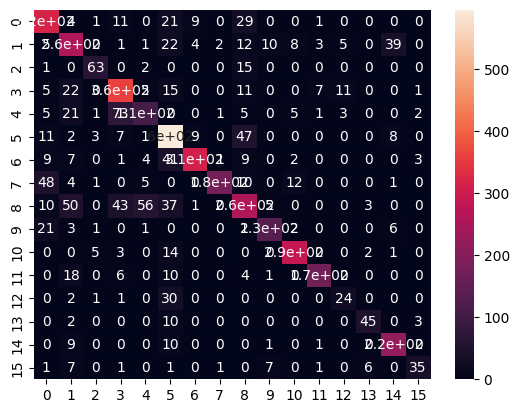

In [25]:
import seaborn as sns
sns.heatmap(cf_mat, annot=True)

In [28]:
torch.save(fcmodel.state_dict(),'NLPmodel2.pth')